In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs

#Create the portfolio
portfolio = pd.DataFrame(["AAA"]*10+["AA"]*10+["A"]*10, columns = ['Rating'])
portfolio['Coupon Rate'] = [.08] * 10 + [.09] * 10 + [.1] * 10
portfolio['Payment Frequency'] = [6,12] * 15
portfolio['Face Value'] = 1000
print(portfolio)

#Set initial portfolio
initial_state = {
    'portfolio': portfolio,
    'default': 0,
    'cash': 0,
    'payment': 0,
    'r': .06
}

   Rating  Coupon Rate  Payment Frequency  Face Value
0     AAA         0.08                  6        1000
1     AAA         0.08                 12        1000
2     AAA         0.08                  6        1000
3     AAA         0.08                 12        1000
4     AAA         0.08                  6        1000
5     AAA         0.08                 12        1000
6     AAA         0.08                  6        1000
7     AAA         0.08                 12        1000
8     AAA         0.08                  6        1000
9     AAA         0.08                 12        1000
10     AA         0.09                  6        1000
11     AA         0.09                 12        1000
12     AA         0.09                  6        1000
13     AA         0.09                 12        1000
14     AA         0.09                  6        1000
15     AA         0.09                 12        1000
16     AA         0.09                  6        1000
17     AA         0.09      

In [2]:
#Function to compute bond payments
def bond_payments(_params, substep, sH, s):
    #Compute coupon payments 
    payment = (((s['timestep']+1) % portfolio['Payment Frequency']) == 0).astype(int) * portfolio['Coupon Rate'] * portfolio['Face Value'] * portfolio['Payment Frequency'] / 12
    
    #If the timestep is equal to 360, add the face value
    payment = payment + portfolio['Face Value'] * ((s['timestep'] + 1) % 360 == 0)
    
    #Set payments for defaulted bonds equal to 0
    payment = payment * (portfolio['Rating'] != 'Default').astype(int)
    
    payment = payment.sum()
    return ({"payment": payment})

#Update the payment    
def update_payments(params, step, sL, s, _input):
    return ('payment', _input['payment'])

In [3]:
#Partial updates
PSUBs = [
    {
        "policies": {
            "payment_policy": bond_payments,
        },
        "variables": {
            "payment": update_payments,
        }
    }
]

#Set simulation parameters

#The M parameter will let us test different combinations of parameters
sim_config_dict = {
    'T': range(360),
    'N': 5}

c = config_sim(sim_config_dict)


exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)


exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)

simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (360, 1, 5, 5)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4]
ExpIDs   : [0, 0, 0, 0, 0]
Total execution time: 3.34s


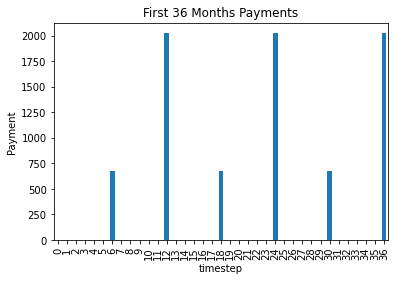

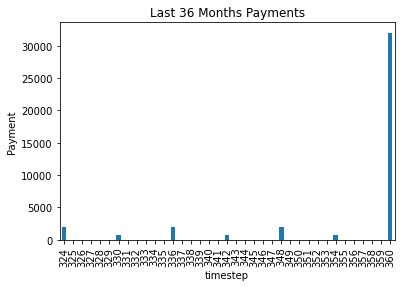

In [4]:
payments = result.groupby('timestep')['payment'].mean()
payments.iloc[:37].plot(kind='bar')
plt.title("First 36 Months Payments")
plt.ylabel("Payment")
plt.show()
payments.iloc[-37:].plot(kind='bar')
plt.title("Last 36 Months Payments")
plt.ylabel("Payment")
plt.show()

In [5]:
import pathos
pathos.helpers.shutdown()
configs.clear()

In [6]:
#New functions

#Compute cash
def cash_change(_params, substep, sH, s):
    #Accumulate the cash
    cash = s['cash'] * (1+s['r']) ** (1/12)
    cash += s['payment']
    return ({"cash": cash})

#Update cash
def update_cash(params, step, sL, s, _input):
    return ('cash', _input['cash'])

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs


#Partial updates
PSUBs = [
    {
        "policies": {
            "payment_policy": bond_payments,
        },
        "variables": {
            "payment": update_payments,
        }
    },
        {
        "policies": {
            "cash_policy": cash_change,
        },
        "variables": {
            "cash": update_cash,
        }
    }
]

#Set simulation parameters

#The M parameter will let us test different combinations of parameters
sim_config_dict = {
    'T': range(360),
    'N': 5}

c = config_sim(sim_config_dict)


exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)


exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)

simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (360, 1, 5, 5)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4]
ExpIDs   : [0, 0, 0, 0, 0]
Total execution time: 5.50s


In [8]:
cash_ts = result[result['substep'] == 2].groupby('timestep')['cash'].mean()
print(cash_ts)

timestep
1           0.000000
2           0.000000
3           0.000000
4           0.000000
5           0.000000
           ...      
356    208912.350778
357    209929.242209
358    210951.083411
359    211977.898476
360    245034.711616
Name: cash, Length: 360, dtype: float64


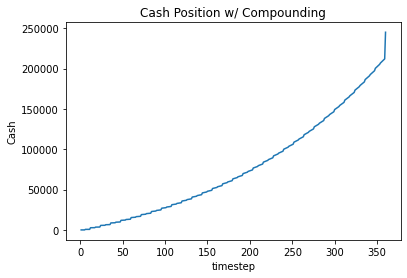

In [9]:
cash_ts.plot(kind='line')
plt.title("Cash Position w/ Compounding")
plt.ylabel("Cash")
plt.show()